In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import json
import subprocess
from datetime import datetime
from platformdirs import user_cache_dir
from hashlib import blake2b
from difflib import get_close_matches

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from typing import List


import ms_pred.common as common
from ms_pred.retrieval.retrieval_benchmark import entropy_dist_bin, emd_dist_bin

/home/mrunali/miniconda3/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/runzhong/ms-pred

/mnt/home/runzhong/ms-pred


The following cell enables SA score. See instructions in https://greglandrum.github.io/rdkit-blog/posts/2023-12-01-using_sascore_and_npscore.html

In [3]:
# sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
sys.path.append(os.path.join('/home/runzhong/miniforge3/envs/ms-main','share','RDKit','Contrib'))
from SA_Score import sascorer

ModuleNotFoundError: No module named 'SA_Score'

# Global configs

In [8]:
config = dict(
    python_path='/home/mrunali/miniconda3/envs/ms-gen/bin/python',
    gen_ckpt='/home/runzhong/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt',
    inten_ckpt='/home/runzhong/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt',
    cuda_devices=1,
    batch_size=8,
    num_workers=6,
    sparse_k=100,
    max_nodes=100,
    threshold=0.0,
    binned_out=False,
    ppm=20,
    num_bins=15000,
)

# Declare methods

In [15]:
def candidates_from_pubchem(
    formula:str,
    pubchem_form_map:str='/home/runzhong/foam/data/pubchem/pubchem_formulae_inchikey.hdf5',
):
    """
    Get structural candidates with the same chemical formula from pubchem

    Args:
        formula: chemical formula of interested
        pubchem_form_map: path to a pubchem mapping file

    Returns: list of SMILES

    """

    form_to_smi_mapping = common.HDF5Dataset(pubchem_form_map)
    smiles_inchikey = json.loads(form_to_smi_mapping.read_str(formula))
    smiles = [_[0] for _ in smiles_inchikey]

    # remove stereo chemistry and duplicates
    smiles = np.array([common.rm_stereo(smi) for smi in smiles])
    charge = np.array([Chem.GetFormalCharge(Chem.MolFromSmiles(smi)) for smi in smiles])
    smiles = smiles[charge == 0]
    inchikey = [common.inchikey_from_smiles(smi) for smi in smiles]
    _, unique_ids = np.unique(inchikey, return_index=True)
    smiles = smiles[unique_ids]
    return smiles


def iceberg_prediction(
    candidate_smiles:List[str],
    collision_energies:List[int],
    nce:bool=False,
    adduct:str='[M+H]+',
    exp_name:str='iceberg_elucidation',
    python_path:str='/home/roger/miniforge3/envs/ms-main/bin/python',
    gen_ckpt:str='/home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt',
    inten_ckpt:str='/home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt',
    cuda_devices:int=0,
    batch_size:int=8,
    num_workers:int=6,
    sparse_k:int=100,
    max_nodes:int=100,
    threshold:float=0.1,
    binned_out:bool=False,
    ppm:int=20,
    **kwargs,
):
    """
    Run ICEBERG prediction over a candidate set of molecules

    Args:
        candidate_smiles: (list[str]) list of candidate SMILES
        collision_energies: (list[int]) list of collision energies
        nce: (bool, default=False) if True, the collision energies are treated as normalized collision energy; otherwise, they are treated as absolute eV
        adduct: (str, default='[M+H]+') adduct type
        exp_name: (str, default='iceberg_elucidation') name of the experiment
        python_path: (str) path to python executable
        gen_ckpt: (str) path to ICEBERG generator model (model 1) checkpoint
        inten_ckpt: (str) path to ICEBERG intensity model (model 2) checkpoint
        cuda_devices: (int or list) CUDA visible devices
        batch_size: (int, default=8)
        num_workers: (int, default=6) number of parallel workers
        sparse_k: (int, default=100) number of unique peaks predictred by model 2
        max_nodes: (int, default=100) number of fragments generated by model 1
        threshold: (float, default=0.1) cutoff confidence for model 1
        binned_out: (bool, default=False) if True, model outputs binned spectrum; otherwise, model outputs high-precision m/z peaks
        ppm: (int, default=20) parts-per-million threshold for mass comparison

    Returns: path to results (a temporary path that hashes all experiment parameters),
             precursor mass
    """
    #########################################
    #       Check & preprocess input        #
    #########################################

    python_path = Path(python_path)
    gen_ckpt = Path(gen_ckpt)
    inten_ckpt = Path(inten_ckpt)

    # cuda devices as string
    if isinstance(cuda_devices, list):
        cuda_devices = ','.join([str(_) for _ in cuda_devices])
    elif isinstance(cuda_devices, int):
        cuda_devices = str(cuda_devices)
    assert isinstance(cuda_devices, str)

    # check adduct type
    if not adduct in common.ion2mass:
        matches = get_close_matches(adduct, common.ion2mass.keys(), n=1, cutoff=0.7)
        if len(matches) > 0:
            raise ValueError(f'Unknown adduct {adduct}. Did you mean {matches[0]}? ')
        else:
            raise ValueError(f'Adduct type {adduct} is not supported. Supported adducts: '
                             f'{list(common.ion2mass.keys())}')

    # remove stereo
    candidate_smiles = [common.rm_stereo(smi) for smi in candidate_smiles]

    # remove duplicate inchikeys
    inchikeys = [common.inchikey_from_smiles(smi) for smi in candidate_smiles]
    _, uniq_idx = np.unique(inchikeys, return_index=True)
    candidate_smiles = np.array(candidate_smiles)[uniq_idx].tolist()

    # get formula & mass & check candidate smiles
    precursor_mass = common.mass_from_smi(candidate_smiles[0]) + common.ion2mass[adduct]
    # formula check is skipped
    # formula = common.form_from_smi(candidate_smiles[0])
    for smi in candidate_smiles:
        cur_pm = common.mass_from_smi(smi) + common.ion2mass[adduct]
        if np.abs(precursor_mass - cur_pm) > precursor_mass * ppm * 1e-6:  # ppm diff
            raise ValueError(f'Precursor mass mismatch in input molecules. Got {smi}, mass={cur_pm}, expected mass={precursor_mass} inferred from {candidate_smiles[0]}')
        # if not formula == common.form_from_smi(smi):
        #     raise ValueError(f'Formula mismatch in input molecules. Got {smi}, form={common.form_from_smi(smi)}, expected form={formula} inferred from {candidate_smiles[0]}')

    # handle collision energies, convert all nce to ev
    collision_energies = [float(e) for e in collision_energies]
    if nce:
        collision_energies = [common.nce_to_ev(e, precursor_mass) for e in collision_energies]
    collision_energies = [f'{_:.0f}' for _ in sorted(collision_energies)]

    # generate temp directory
    param_str = exp_name + '||' + ';'.join(sorted(candidate_smiles)) + '||' + str(common.ion2onehot_pos[adduct]) + \
                '||' + ';'.join(collision_energies) + '||' + str(gen_ckpt.absolute()) + '||' + str(inten_ckpt.absolute()) + \
                '||' + cuda_devices + '||' + f'{batch_size:d}-{num_workers:d}-{sparse_k:d}-{max_nodes:d}||' + f'{threshold:.2f}' + \
                '||' + ('binned_out' if binned_out else "")
    param_hash = blake2b(param_str.encode("ascii"), digest_size=16).hexdigest()
    save_dir = Path(user_cache_dir(f"ms-pred/iceberg-elucidation/{param_hash}"))
    save_dir.mkdir(parents=True, exist_ok=True)

    #########################################
    #            Call ICEBERG               #
    #########################################

    # skip model call if the results are cached
    if not (save_dir / 'iceberg_run_successful').exists():
        # write candidates to tsv
        entries = []
        for smi in candidate_smiles:
            entries.append({
                'spec': exp_name, 'smiles': smi, 'ionization': adduct, 'inchikey': common.inchikey_from_smiles(smi), 'precursor': precursor_mass,
                'collision_energies': collision_energies,
            })
        df = pd.DataFrame.from_dict(entries)
        df.to_csv(save_dir / f'cands_df_{exp_name}.tsv', sep='\t', index=False)

        # run iceberg to generate in-silico spectrum
        cmd = (f'''CUDA_VISIBLE_DEVICES={cuda_devices} {python_path} src/ms_pred/dag_pred/predict_smis.py \\
               --batch-size {batch_size} \\
               --num-workers {num_workers} \\
               --dataset-labels {save_dir / f"cands_df_{exp_name}.tsv"} \\
               --sparse-out \\
               --sparse-k {sparse_k} \\
               --max-nodes {max_nodes} \\
               --threshold {threshold} \\
               --gen-checkpoint {gen_ckpt} \\
               --inten-checkpoint {inten_ckpt} \\
               --save-dir {save_dir} \\
               --gpu \\
               --adduct-shift''')
        assert not binned_out, 'Elucidation not supported for binned_out=True'
        if binned_out:
            cmd += ' \\           --binned_out'
        print(cmd)
        run_result = subprocess.run(cmd, shell=True)
        if run_result.returncode == 0:  # successful
            (save_dir / 'iceberg_run_successful').touch()

    return save_dir, precursor_mass


def load_real_spec(
    real_spec:str,
    real_spec_type:str,
    precursor_mass:float=None,
    nce:bool=False,
    ppm:int=20,
):
    """
    Args:
        precursor_mass:
        nce:
        ppm:
        num_bins:

    Returns:

    """
    if real_spec_type == 'raw':
        meta = {}
    elif real_spec_type == 'ms':
        real_spec_path = Path(real_spec)
        meta, specs = common.parse_spectra(real_spec_path)
        real_spec = common.process_spec_file(meta, specs, merge_specs=False)
    else:
        raise ValueError(f'Unkown spectrum type {real_spec_type}')

    if 'parentmass' in meta:
        if precursor_mass is not None:
            # check if meta is matched
            if np.abs(precursor_mass - float(meta['parentmass'])) > precursor_mass * ppm * 1e-6:
                raise ValueError(f'Precursor mass is different from loaded spectrum metadata! Got m/z={precursor_mass}, loaded from spec={meta["parentmass"]}')
        else:
            precursor_mass = float(meta['parentmass'])
    assert precursor_mass is not None

    # round collision energy to integer
    real_spec = {float(common.get_collision_energy(k)): v for k, v in real_spec.items()}
    if nce:
        real_spec = {common.nce_to_ev(k, precursor_mass): v for k, v in real_spec.items()}
    real_spec = {f'{k:.0f}': v for k, v in real_spec.items()}
    return real_spec


def load_pred_spec(
    load_dir:str,
    step_collision_energy:bool,
):
    """
    Args:
        load_dir: str
        step_collision_energy: bool

    Returns:

    """
    load_dir = Path(load_dir)

    pred_specs = common.HDF5Dataset(load_dir / 'preds.hdf5')
    pred_spec_ars = []
    pred_smis = []
    pred_frags = []
    # iterate over h5 layers
    for pred_spec_obj in pred_specs.h5_obj.values():
        for smiles_obj in pred_spec_obj.values():
            smi = None
            spec_dict = {}
            frag_dict = {}
            for collision_eng_key, collision_eng_obj in smiles_obj.items():
                if smi is None:
                    smi = collision_eng_obj.attrs['smiles']
                collision_eng_key = common.get_collision_energy(collision_eng_key)
                spec_dict[collision_eng_key] = collision_eng_obj['spec'][:]
                frag_dict[collision_eng_key] = json.loads(collision_eng_obj['frag'][0])

            if step_collision_energy:
                mz_frag_to_tup = {}
                for collision_eng_key in spec_dict.keys():
                    for spec, frag in zip(spec_dict[collision_eng_key], frag_dict[collision_eng_key]):
                        mz, inten = spec
                        mz_frag = f'{mz:.4f}_{frag}'
                        cur_tup = mz_frag_to_tup.get(mz_frag)
                        if cur_tup is None:
                            mz_frag_to_tup[mz_frag] = [mz, inten, frag]
                        else:
                            cur_tup[1] += inten

                merged_spec, merged_frag = [], []
                for tup in mz_frag_to_tup.values():
                    merged_spec.append((tup[0], tup[1]))
                    merged_frag.append(tup[2])
                merged_spec = np.array(merged_spec)
                merged_spec[:, 1] = merged_spec[:, 1] / merged_spec[:, 1].max()
                spec_dict['nan'] = merged_spec  # 'nan' means merged
                frag_dict['nan'] = np.array(merged_frag)

            pred_spec_ars.append(spec_dict)
            pred_frags.append(frag_dict)
            pred_smis.append(smi)
    pred_specs.close()
    pred_specs = np.array(pred_spec_ars)
    smiles = np.array(pred_smis)

    return smiles, pred_specs, pred_frags


def elucidation_over_candidates(
    load_dir:str,
    real_spec:str,
    real_spec_type:str='ms',
    precursor_mass:float=None,
    nce:bool=False,
    step_collision_energy:bool=False,
    mol_name:str="",
    real_smiles:str=None,
    topk:int=10,
    ppm:int=20,
    num_bins:int=15000,
    dist_fn=entropy_dist_bin,
    return_specs=False,
    **kwargs,
):
    """
    Run elucidation over a candidate set

    Args:
        load_dir: (str) path to result directory (return of function iceberg_prediction)
        real_spec: (str) the real spectrum. Depends on real_spec_type
        real_spec_type: (str, default='ms') 'ms': SIRIUS-style spectrum file (.ms), 'raw': processed dictionary
        precursor_mass: (float) mass of the precursor ion
        nce: (bool, default=False) if True, the collision energies are treated as normalized collision energy; otherwise, they are treated as absolute eV
        step_collision_energy: (bool, default=False) if True, it means step_collision_energy is turned on in the instrument and only one merged spectrum will be returned
        mol_name: (str, default="") name of the molecule and/or experiment
        real_smiles: (str, default=None) the real SMILES, if specified
        topk: (int, default=10) number of candidates returned
        ppm: (int, default=20) parts-per-million threshold for mass comparison
        num_bins: (int, default=15000) number of bins for binned spectrum

    Returns: list of TopK molecules:
        [ (top1 SMILES, entropy distance, true molecule or not),
          (top2 SMILES, entropy distance, true molecule or not),
          ...
          (topK SMILES, entropy distance, true molecule or not),
        ]

    """
    real_spec = load_real_spec(real_spec, real_spec_type, precursor_mass, nce, ppm)
    smiles, pred_specs, pred_frags = load_pred_spec(load_dir, step_collision_energy)

    # transform spec to binned spectrum
    real_binned = {k: common.bin_spectra([v], num_bins)[0] for k, v in real_spec.items()}
    pred_binned_specs = [
        {k: common.bin_spectra([v], num_bins, pool_fn='add')[0] for k, v in s.items()}
        for s in pred_specs]

    # get target inchikey (if any)
    if real_smiles is not None:
        target_inchikey = common.inchikey_from_smiles(common.rm_stereo(real_smiles))
    else:
        target_inchikey = None

    # compute distance
    # dist = entropy_dist_bin(pred_binned_specs, real_binned, ignore_peak=(precursor_mass - 1) * 10, sparse=False)
    dist = dist_fn(pred_binned_specs, real_binned, ignore_peak=(precursor_mass - 1) * 10, sparse=False)

    sorted_indices = np.argsort(dist)

    found_true = False
    true_idx = -1
    for rnk, idx in enumerate(sorted_indices):
        d = dist[idx]
        smi = smiles[idx]
        inchikey = common.inchikey_from_smiles(smi)
        if target_inchikey is not None and inchikey in target_inchikey:
            print((f'[{mol_name}] ' if len(mol_name) > 0 else "") + f'Found target mol at {rnk+1}/{len(sorted_indices)+1}, ent_dist={d:.3f}')
            found_true = True
            true_idx = idx
        if idx >= topk and found_true:
            break
    if not return_specs:
        return [(smiles[i], dist[i], i == true_idx) for i in sorted_indices[:topk]]
    else: 
        return [(smiles[i], dist[i], i == true_idx) for i in sorted_indices[:topk]], (real_binned, pred_binned_specs)


def plot_top_mols(
    topk_results,
    sa_score=False,
):
    """
    Turn the output of elucidation_over_candidates into plot

    Args:
        topk_results:

    Returns:
        an image object
    """
    mols = []
    legends = []
    for rnk, (smi, dist, is_true) in enumerate(topk_results):
        mol = Chem.MolFromSmiles(smi)
        mols.append(mol)
        legend_str = f"top{rnk+1} ent_dis={dist:.3f}"
        if sa_score:
            sa = sascorer.calculateScore(mol)
            legend_str += f" SA={sa:.3f}"
        if is_true:
            legend_str += '\ntrue molecule'
        legends.append(legend_str)
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250,250), legends=legends, maxMols=len(mols))


def explain_peaks(
    load_dir:str,
    real_spec:str,
    precursor_mass:float,
    mol_str:str,
    real_spec_type:str='ms',
    mol_type:str='smi',
    num_peaks:int=5,
    nce:bool=False,
    step_collision_energy:bool=False,
    ppm:int=20,
    **kwargs,
):
    """
    Plot experiment spectrum and predicted spectrum head-to-head and explain the peaks using ICEBERG predictions

    Args:
        load_dir: (str) path to result directory (return of function iceberg_prediction)
        real_spec: (str) path to the experimental spectrum (.ms file)
        precursor_mass: (float) mass of the precursor ion
        mol_str: (str) the molecule of interest
        real_spec_type: (str, default='ms') 'ms': SIRIUS-style spectrum file (.ms), 'raw': processed dictionary
        mol_type: (str, default='smi') type of mol_str. Supported values: 'smi' (SMILIES), 'inchi' (InChi), 'mol' (RDKit molecule objedt), 'inchikey' (InChiKey)
        num_peaks: (int, default=5) number of peaks to explain
        nce: (bool, default=False) if True, the collision energies are treated as normalized collision energy; otherwise, they are treated as absolute eV
        step_collision_energy: (bool, default=False) if True, it means step_collision_energy is turned on in the instrument and only one merged spectrum will be returned
        ppm: (int, default=20) parts-per-million threshold for mass comparison
    """
    from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
    import ms_pred.magma.fragmentation as fragmentation


    real_spec = load_real_spec(real_spec, real_spec_type, precursor_mass, nce, ppm)
    smiles, pred_specs, pred_frags = load_pred_spec(load_dir, step_collision_energy)
    cand_inchikeys = [common.inchikey_from_smiles(common.rm_stereo(smi)) for smi in smiles]

    if mol_type == 'smi':
        inchikey_of_interest = common.inchikey_from_smiles(common.rm_stereo(mol_str, mol_type))
    elif mol_type == 'mol':
        inchikey_of_interest = Chem.MolToInchikey(common.rm_stereo(mol_str, mol_type))
    elif mol_type == 'inchi':
        inchikey_of_interest = Chem.InchiToInchikey(common.rm_stereo(mol_str, mol_type))
    elif mol_type == 'inchikey':
        inchikey_of_interest = mol_str
    else:
        raise ValueError(f'mol_type={mol_type} is not supported')

    if not inchikey_of_interest in cand_inchikeys:
        print('No inchikey matching is found for the compound of interested')
        return

    idx = cand_inchikeys.index(inchikey_of_interest)
    smi = smiles[idx]
    engine = fragmentation.FragmentEngine(smi, mol_str_type='smiles')

    for ce in sorted(real_spec.keys()):
        pred_spec = pred_specs[idx][ce]
        pred_frag = pred_frags[idx][ce]
        common.plot_compare_ms(real_spec[ce], pred_spec, 'experiment', 'predicted',  f'collision energy {ce}eV', dpi=1000)  # changed for pdf view. was dpi=500

        plt.gca().set_ylim(-1.1, 1.1)

        counter = 0
        pred_spec[:, 1] = pred_spec[:, 1] / np.max(pred_spec[:, 1])
        for spec, frag in zip(pred_spec, pred_frag):
            mz, inten = spec
            draw_dict = engine.get_draw_dict(frag)
            frag_img = Draw.MolToImage(draw_dict["mol"], highlightAtoms=draw_dict["hatoms"], highlightBonds=draw_dict["hbonds"])
            frag_img = np.concatenate((np.array(frag_img), 255 * np.ones((frag_img.size[0], frag_img.size[1], 1), dtype=np.int8)), axis=-1)
            frag_img = np.where(((frag_img[:, :, :3] == np.array([255, 255, 255])[None, None, :]).sum(axis=-1) == 3)[:, :, None],
                                  np.zeros_like(frag_img), frag_img) # make white background transparent
            imagebox = OffsetImage(frag_img, zoom = 0.05)  # changed for pdf view. was zoom=0.2
            ab = AnnotationBbox(imagebox, (mz, - inten - 0.05), frameon = False)  # changed for pdf view. was -0.1
            plt.gca().add_artist(ab)
            plt.text(mz, - inten - 0.1, f'{mz:.3f}', fontsize=2) # changed for pdf view. was -0.2,font_size=5
            counter += 1
            if counter >= num_peaks:
                break

# Elucidation on Pesticide Degradation

In [ ]:
inp_mgf = '/home/roger/ms_collaborators/Joules-Pesticide/sirius.mgf'
candidates_csv = '/home/roger/ms_collaborators/Joules-Pesticide/chemical_transformation_predictions.csv'

# load mgf and candidates
all_specs = common.parse_spectra_mgf(inp_mgf)
feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if entry[0]['MSLEVEL'] == '2'
}
all_candidates = pd.read_csv(candidates_csv)

In [ ]:
# Run SIRIUS to explain formula
profile = 'orbitrap'
ppm_max = 5
sirius_path = '/home/roger/miniforge3/envs/ms-main/bin/sirius'

out_dir = Path(user_cache_dir(f"ms-pred/sirius-out-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"))
out_dir.mkdir(parents=True, exist_ok=True)

# sirius_command = (f'/home/roger/miniforge3/condabin/conda run -n ms-main '
#                   f'sirius --version')
sirius_command = (f'/home/roger/miniforge3/condabin/conda run -n ms-main '
                  f'sirius -o {out_dir} '
                  f'-i {inp_mgf} '
                  f'--ignore-formula --noCite formula '
                  f'-p {profile} --ppm-max={ppm_max} write-summaries')
print("Running SIRIUS, command:\n" + sirius_command + "\n")
subprocess.run(sirius_command, shell=True)

In [ ]:
top_k_sirius_preds = 5
# prepare entries
feat_id_to_dict = {}
for per_cmpd_out_dir in out_dir.glob('*'):
    feature_id = per_cmpd_out_dir.stem.split('_')[-1]
    sirius_cands_path = per_cmpd_out_dir / 'formula_candidates.tsv'
    if sirius_cands_path.exists():
        adduct_to_smiles = {}
        df = pd.read_csv(sirius_cands_path, sep='\t')
        for idx, sirius_row in df.iterrows():
            if idx >= top_k_sirius_preds:
                continue
            adduct = sirius_row['adduct'].replace(" ", "")
            for cand_form, cand_smi in zip(all_candidates['formula'], all_candidates['smiles']):
                diff = common.formula_difference(sirius_row['molecularFormula'], cand_form)
                if len(diff) == 0:  # same formula
                    if adduct in adduct_to_smiles:
                        adduct_to_smiles[adduct].append(cand_smi)
                    else:
                        adduct_to_smiles[adduct] = [cand_smi]
        if len(adduct_to_smiles) > 0:
            # remove duplicate inchikey
            for adduct, smiles in adduct_to_smiles.items():
                inchikeys = [common.inchikey_from_smiles(smi) for smi in smiles]
                _, uniq_idx = np.unique(inchikeys, return_index=True)
                adduct_to_smiles[adduct] = np.array(smiles)[uniq_idx].tolist()

            feat_id_to_dict[feature_id] = {
                'feature_id': feature_id,
                'spec': {'nan': feat_id_to_specs[feature_id]},
                'adduct_to_smiles': adduct_to_smiles,
            }

In [ ]:
def pesticide_elucidation(info_dict, vis_peaks=False):
    pesticide_config = copy.deepcopy(config)
    pesticide_config['nce'] = True # use nce for collision energy
    pesticide_config['step_collision_energy'] = True  # step collision energy i.e. multiple spectrum are obtained then merged
    pesticide_config['real_spec_type'] = 'raw'

    for adduct, smiles in info_dict['adduct_to_smiles'].items():
        pesticide_config['adduct'] = adduct

        # Run ICEBERG to predict spectra
        result_path, pmz = iceberg_prediction(smiles, [30, 40, 60], **pesticide_config)

        # Compare spectrum similarity for elucidation
        topk_results = elucidation_over_candidates(result_path, info_dict["spec"], precursor_mass=pmz, mol_name=info_dict["feature_id"], topk=10, **pesticide_config)

        # Plot top results
        img = plot_top_mols(topk_results)

        # Visualize and explain peaks
        if vis_peaks:
            for cand_smi in smiles:
                explain_peaks(result_path, info_dict["spec"], pmz, cand_smi, num_peaks=10, **pesticide_config)

        return img

pesticide_elucidation(feat_id_to_dict['5421'], True)

In [ ]:
# write feature matchings for analysis

row_to_match = {}
for i in feat_id_to_dict.values():
    for adduct, smis in i['adduct_to_smiles'].items():
        for smi in smis:
            for row_idx in all_candidates.index[all_candidates['smiles'] == smi]:
                if row_idx not in row_to_match:
                    row_to_match[row_idx] = f"feat_id={i['feature_id']}, {adduct}"
                else:
                    row_to_match[row_idx] += f"; feat_id={i['feature_id']}, {adduct}"
all_candidates['matched features'] = row_to_match
all_candidates.to_csv(candidates_csv + '2', index=False)
all_candidates

In [ ]:
for i in feat_id_to_dict.values():
    print(i['feature_id'], i['adduct_to_smiles'])

# Elucidation on Withanolide data

In [ ]:
def spec_from_csv(csv_paths, precursor, colli_eng='collision 30', ppm=20):
    clean_ref_spec = None
    for csv_path in csv_paths:
        spec_df = pd.read_csv(csv_path, header=2)
        ref_spec = common.process_spec_file({'parentmass': precursor}, [(colli_eng, np.array(spec_df))], merge_specs=False)
        if clean_ref_spec is None:
            clean_ref_spec = ref_spec
        else:
            new_clean_peaks = []
            for mz, inten in clean_ref_spec[colli_eng]:
                match = np.abs(mz - ref_spec[colli_eng][:, 0]) / mz < 1e-6 * ppm  # only keep peaks that exist in all replicates
                if np.any(match):
                    otherinten = ref_spec[colli_eng][np.where(match), 1]
                    new_clean_peaks.append((mz, inten + otherinten.item()))
            clean_ref_spec = {colli_eng: np.array(new_clean_peaks)}
    clean_ref_spec[colli_eng][:, 1] /= np.max(clean_ref_spec[colli_eng][:, 1])
    return clean_ref_spec

def mol_ok(mol):
    try:
        Chem.SanitizeMol(mol)
        return True
    except ValueError:
        return False

def ring_OK(mol):
    if not mol.HasSubstructMatch(Chem.MolFromSmarts("[R]")):
        return True

    ring_allene = mol.HasSubstructMatch(Chem.MolFromSmarts("[R]=[R]=[R]"))

    cycle_list = mol.GetRingInfo().AtomRings()
    max_cycle_length = max([len(j) for j in cycle_list])
    macro_cycle = max_cycle_length > 6

    double_bond_in_small_ring = mol.HasSubstructMatch(
        Chem.MolFromSmarts("[r3,r4]=[r3,r4]")
    )

    return not ring_allene and not macro_cycle and not double_bond_in_small_ring

def generate_candidates(base_mols, all_rxn_smarts):
    iterable = True
    try:
        _ = iter(base_mols)
    except TypeError as te:
        iterable = False

    if not iterable:
        base_mols = [base_mols]

    candidate_pathways = []
    all_new_mols = []
    for rxn_smarts in all_rxn_smarts:
        rxn = AllChem.ReactionFromSmarts(rxn_smarts)
        for base_mol in base_mols:
            new_mol_trial = rxn.RunReactants((base_mol,))
            new_mols = np.array([mol[0] for mol in new_mol_trial if mol_ok(mol[0]) and ring_OK(mol[0])])
            new_inchikey = np.array([Chem.MolToInchiKey(mol) for mol in new_mols])
            _, indices = np.unique(new_inchikey, return_index=True)
            new_mols = new_mols[indices]
            candidate_pathways += [(Chem.MolToSmiles(base_mol), Chem.MolToSmiles(m)) for m in new_mols]
            all_new_mols += new_mols.tolist()

    new_inchikey = np.array([Chem.MolToInchiKey(mol) for mol in all_new_mols])
    _, indices = np.unique(new_inchikey, return_index=True)
    all_new_mols = np.array(all_new_mols)[indices]
    return all_new_mols, candidate_pathways

def add_atom(base_mols, new_atom='O'):  # Hydrogen is ignored, new_atom='C' means 'CH2'
    all_rxn_smarts = [
        "[*:1]>>[*:1]X".replace("X", new_atom),  # append
        # "[*:1]-[*:2]>>[*:1]X[*:2]".replace("X", new_atom),  # insert
    ]
    if new_atom == 'O':
        all_rxn_smarts.append(
            "[*:1]=[*:2]>>[*:1]1X[*:2]1".replace("X", new_atom),  # double bond -> C-O-C ring
        )
    return generate_candidates(base_mols, all_rxn_smarts)

def add_unsaturation(base_mols):  # add double bond or add one ring
    all_rxn_smarts = [
        "[*:1]-[*:2]>>[*:1]=[*:2]",  # single bond -> double bond
        "[*:1]=[*:2]>>[*:1]#[*:2]",  # double bond -> triple bond
        "[*;!r;!H0:1]~[*;!r:2]~[*;!r;!H0:3]>>[*:1]1~[*:2]~[*:3]1",  # rings
        "[*;!r;!H0:1]~[*!r:2]~[*!r:3]~[*;!r;!H0:4]>>[*:1]1~[*:2]~[*:3]~[*:4]1",
        "[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*;!r;!H0:5]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]1",
        "[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*!r:5]~[*;!r;!H0:6]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]~[*:6]1",
    ]
    return generate_candidates(base_mols, all_rxn_smarts)

def withanolide_elucidation(meta, visual_peaks=False):
    withanolide_config = copy.deepcopy(config)
    withanolide_config['real_spec_type'] = 'raw'
    withanolide_config['adduct'] = meta["adduct"]

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(meta["candidate_smiles"], [30], **withanolide_config)

    # Compare spectrum similarity for elucidation
    topk_results = elucidation_over_candidates(result_path, meta["ref_spec"], precursor_mass=pmz, mol_name=meta["cmpd_name"], topk=30, **withanolide_config)

    # Plot top results
    img = plot_top_mols(topk_results)

    # Visualize and explain peaks
    if visual_peaks:
        if 'real_smi' in meta:
            all_smiles = [meta['real_smi']]
        else:
            all_smiles = meta["candidate_smiles"]
        for smi in all_smiles:
            explain_peaks(result_path, meta["ref_spec"], pmz, smi, num_peaks=10, **withanolide_config)

    return img

In [ ]:
precursor = common.rm_stereo(r'C[C@]12C(C[C@@H](O)CC2)=CC[C@]3([H])[C@]1([H])CC[C@@]4(C)[C@@]3([H])CC[C@@H]4[C@H](C)CC/C(C)=C(C)/C')
cmpd1_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)CC2)=CC[C@]3([H])[C@]1([H])CC[C@@]4(C)[C@@]3([H])CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(C)/C')
cmpd5_smi = common.rm_stereo(r'CC(C)=C(C)CC(O)C(C)C1CCC2C3CC=C4CC(O)CC(O)C4(C)C3CCC12C')
cmpd35_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)C[C@@H]2O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(CO)/C')
cmpd36_smi = common.rm_stereo(r'C[C@]12C(C[C@@H](O)CC2O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(C(C)=C(C)C5)=O')

withanolide_meta = {}

withanolide_meta['cmpd1'] = {
    "cmpd_name": "cmpd1",
    "precursor": 397.3465,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd1-ms2',
    "replicate_suffix": ('1', '2', '3'),
    "start_smi": precursor,
    "form_change": '+O',
    "real_smi": cmpd1_smi,
}

withanolide_meta['cmpd5'] = {
    "cmpd_name": "cmpd5",
    "precursor": 413.3415,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd5-ms2',
    "replicate_suffix": ('1', '2'),
    "start_smi": cmpd1_smi,
    "form_change": '+O',
    "real_smi": cmpd5_smi,
}

withanolide_meta['cmpd35'] = {
    "cmpd_name": "cmpd35",
    "precursor": 429.336,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd35-ms2',
    "replicate_suffix": ('1', '2'),
    "start_smi": cmpd5_smi,
    "form_change": '+O',
    "real_smi": cmpd35_smi,
}

# update 2024/07/24
withanolide_meta['cmpd6'] = {
    "cmpd_name": "cmpd6",
    "precursor": 413.3415,
    "adduct": '[M+H-H2O]+',
    "spec_name": 'cmpd6-ms2',
    "replicate_suffix": ('1', '2'),
    "start_smi": cmpd1_smi,
    "form_change": '+O',
}

withanolide_meta['cmpd36'] = {
    "cmpd_name": "cmpd36",
    "precursor": 443.315,
    "adduct": '[M+H]+',
    "spec_name": 'cmpd36-ms2',
    "replicate_suffix": ('1', '2'),
    "candidate_smiles": [cmpd36_smi],
    "real_smi": cmpd36_smi,
}

withanolide_meta['cmpd41'] = {
    "cmpd_name": "cmpd41",
    "precursor": 441.29959,
    "adduct": '[M+H]+',
    "spec_name": 'cmpd41-ms2',
    "replicate_suffix": ('1', '2'),
    "candidate_smiles": [
        common.rm_stereo(r'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(C(C)=C(C)C5)=O'),
        common.rm_stereo(r'C[C@]12C(C[C@@H](O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(C(C)=C(C)C5)=O'),
]
}

withanolide_meta['cmpd42'] = {
    "cmpd_name": "cmpd42",
    "precursor": 521.25675,
    "adduct": '[M+H]+',
    "spec_name": 'cmpd42-ms2',
    "replicate_suffix": ('1', '2'),
    "candidate_smiles": [
        common.rm_stereo(r'C[C@]12C(CC(CC2OS(=O)(O)=O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(C(C)=C(C)C5)=O'),
        common.rm_stereo(r'C[C@]12C(C[C@@H](OS(=O)(O)=O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(C(C)=C(C)C5)=O'),
    ]
}

withanolide_meta['cmpd42-neg'] = {
    "cmpd_name": "cmpd42",
    "precursor": 519.2422,
    "adduct": '[M-H]-',
    "spec_name": 'cmpd42-ms2-neg',
    "replicate_suffix": ('1', '2'),
    "candidate_smiles": [
        common.rm_stereo(r'C[C@]12C(C[C@@H](OS(=O)(O)=O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(C(C)=C(C)C5)=O'),
        common.rm_stereo(r'C[C@]12C(CC(CC2OS(=O)(O)=O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(C(C)=C(C)C5)=O')
    ]
}


# generate candidate smiles
for meta in withanolide_meta.values():
    if "start_smi" in meta:
        start_smi = common.rm_stereo(meta["start_smi"])
        start_mol = Chem.MolFromSmiles(start_smi)
        assert "+" == meta["form_change"][0]
        mol_candidates, _ = add_atom(start_mol, meta["form_change"][1:])
        meta["candidate_smiles"] = [Chem.MolToSmiles(_) for _ in mol_candidates]

    # read spec from csv
    real_spec_paths = [f'/home/roger/ms_collaborators/Erin-withanolide/20240326_withanolide_intermediates_MS2_centroided/{meta["spec_name"]}-{suffix}.csv' for suffix in meta["replicate_suffix"]]
    meta["ref_spec"] = spec_from_csv(real_spec_paths, meta["precursor"])

In [ ]:
withanolide_elucidation(withanolide_meta['cmpd42'], True)
plt.savefig('cmpd42.pdf')

# Modifinder

In [ ]:
def modi_finder(
    formula_diff,
    load_dir,
    mol_str1,
    name1,
    precursor_mass1,
    real_spec1,
    real_spec_type1,
    name2,
    precursor_mass2,
    real_spec2,
    real_spec_type2,
    mol_type1='smi',
    topk_peaks=10,
    return_thresh=0.1,
    nce=False,
    step_collision_energy=False,
    ppm=20,
):
    from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
    import ms_pred.magma.fragmentation as fragmentation

    real_spec1 = load_real_spec(real_spec1, real_spec_type1, precursor_mass1, nce, ppm)
    real_spec2 = load_real_spec(real_spec2, real_spec_type2, precursor_mass2, nce, ppm)

    # find peak matching with formula difference
    if formula_diff[0] == '-':
        mass_diff = -common.formula_mass(formula_diff[1:])
    elif formula_diff[0] == '+':
        mass_diff = common.formula_mass(formula_diff[1:])
    else:
        raise ValueError('formula_diff has to start with \'+\' or \'-\'!')
    assert np.abs(precursor_mass1 + mass_diff - precursor_mass2) < precursor_mass1 * 1e-6 * ppm

    interested_peaks = {}
    for ce, spec2 in real_spec2.items():
        cur_matched_peaks = []
        for mz, inten in spec2:
            shifted_mz_in_spec_a = np.min(np.abs(mz - real_spec1[ce][:, 0] - mass_diff)) / mz < 1e-6 * ppm
            mz_in_spec_a = np.min(np.abs(mz - real_spec1[ce][:, 0])) / mz < 1e-6 * ppm
            if shifted_mz_in_spec_a:
                if mz_in_spec_a:
                    a_idx = np.where(np.abs(mz - real_spec1[ce][:, 0]) / mz < 1e-6 * ppm)[0][0]
                    a_mz, a_inten = real_spec1[ce][a_idx]
                    if inten > a_inten:
                        cur_matched_peaks.append((mz, inten - a_inten))
                else:
                    cur_matched_peaks.append((mz, inten))
        interested_peaks[ce] = np.array(cur_matched_peaks)

    smiles, pred_specs, pred_frags = load_pred_spec(load_dir, step_collision_energy)
    cand_inchikeys = [common.inchikey_from_smiles(common.rm_stereo(smi)) for smi in smiles]

    if mol_type1 == 'smi':
        inchikey_of_interest = common.inchikey_from_smiles(common.rm_stereo(mol_str1, mol_type1))
    elif mol_type1 == 'mol':
        inchikey_of_interest = Chem.MolToInchikey(common.rm_stereo(mol_str1, mol_type1))
    elif mol_type1 == 'inchi':
        inchikey_of_interest = Chem.InchiToInchikey(common.rm_stereo(mol_str1, mol_type1))
    elif mol_type1 == 'inchikey':
        inchikey_of_interest = mol_str1
    else:
        raise ValueError(f'mol_type={mol_type1} is not supported')

    if not inchikey_of_interest in cand_inchikeys:
        print('No inchikey matching is found for the compound of interested')
        return

    idx = cand_inchikeys.index(inchikey_of_interest)
    smi = smiles[idx]
    engine = fragmentation.FragmentEngine(smi, mol_str_type='smiles')

    modi_site_imgs = []
    for ce, int_peaks in interested_peaks.items():
        # find peak matching and plot peaks
        peak_matching = np.abs(int_peaks[:, 0][:, None] - real_spec2[ce][:, 0][None, :]) < int_peaks[:, 0][:, None] * 1e-6 * ppm
        common.plot_compare_ms(int_peaks, real_spec2[ce], name1 + f'{formula_diff}', name2, f'# of matched peaks={np.sum(peak_matching.max(axis=-1))}', dpi=500)

        # find fragments to peaks
        counter = 0
        pred_specs[idx][ce][:, 1] = pred_specs[idx][ce][:, 1] / np.max(pred_specs[idx][ce][:, 1])
        sorted_idx = np.argsort(int_peaks[:, 1])[::-1]
        atom_scores = np.zeros(engine.natoms)
        for i in sorted_idx:
            mz, inten = int_peaks[i]
            peak_matching = np.abs(mz - mass_diff - pred_specs[idx][ce][:, 0]) < mz * 1e-6 * ppm
            plot_count = 0
            covered_bitmap = 0
            for j in np.where(peak_matching)[0]:
                covered_bitmap = covered_bitmap | pred_frags[idx][ce][j]  # bit-wise OR
                draw_dict = engine.get_draw_dict(pred_frags[idx][ce][j])
                frag_img = Draw.MolToImage(draw_dict["mol"], highlightAtoms=draw_dict["hatoms"], highlightBonds=draw_dict["hbonds"])
                frag_img = np.concatenate((np.array(frag_img), 255 * np.ones((frag_img.size[0], frag_img.size[1], 1), dtype=np.int8)), axis=-1)
                frag_img = np.where(((frag_img[:, :, :3] == np.array([255, 255, 255])[None, None, :]).sum(axis=-1) == 3)[:, :, None],
                                      np.zeros_like(frag_img), frag_img) # make white background transparent
                imagebox = OffsetImage(frag_img, zoom = 0.15)
                ab = AnnotationBbox(imagebox, (mz, inten + plot_count * 0.15), frameon = False)
                plt.gca().add_artist(ab)
                plot_count += 1
            covered_atoms = engine.get_present_atoms(covered_bitmap)[0]
            if len(covered_atoms) == 0:
                print(f'Uncovered peak: {mz:.5f}, {inten:.2f}')
            else:
                print(f'Covered peak: {mz:.5f}, {inten:.2f}')
            atom_scores[covered_atoms] += inten
            counter += 1
            if counter >= topk_peaks:
                break

        # draw modification site
        img = Draw.MolToImage(engine.mol, highlightAtoms=(np.where(atom_scores > atom_scores.max() - return_thresh)[0]).tolist())
        modi_site_imgs.append(img)

    return modi_site_imgs

In [ ]:
meta1 = withanolide_meta['cmpd1']
meta2 = withanolide_meta['cmpd6']
form_diff = '+O'

assert meta1['adduct'] == meta2['adduct']
withanolide_config = copy.deepcopy(config)
withanolide_config['real_spec_type'] = 'raw'
withanolide_config['adduct'] = meta1["adduct"]
withanolide_config['max_nodes'] = 500
withanolide_config['sparse_k'] = 500

# Run ICEBERG to predict spectra for mol1
result_path, pmz = iceberg_prediction(meta1["candidate_smiles"], [30], **withanolide_config)

imgs = modi_finder(
    form_diff, result_path, meta1["real_smi"],
    meta1["cmpd_name"], meta1["precursor"], meta1["ref_spec"], "raw",
    meta2["cmpd_name"], meta2["precursor"], meta2["ref_spec"], "raw",
    topk_peaks=15, return_thresh=0.1
)
for img in imgs:
    plt.figure()
    plt.axis('off')
    plt.title('Possible modification sites')
    plt.imshow(img)

# Elucidation on Broad data

In [17]:
def broad_elucidation(spec_file, formula, real_smi=None, name="", vis_peaks=False, dist_fn=entropy_dist_bin):
    broad_config = copy.deepcopy(config)
    broad_config['nce'] = True # use nce for collision energy
    exp_spec_path = f'/home/mrunali/data/spec_files/{spec_file}.ms'

    # Get candidates
    smiles = candidates_from_pubchem(formula)

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, [10, 20, 30, 40, 50], **broad_config)

    # Compare spectrum similarity for elucidation
    topk_results, specs = elucidation_over_candidates(result_path, exp_spec_path, precursor_mass=pmz, 
                                               mol_name=name, real_smiles=real_smi, dist_fn=dist_fn, return_specs=True, **broad_config)

    # Plot top results
    img = plot_top_mols(topk_results)

    # Visualize and explain peaks
    if vis_peaks:
        explain_peaks(result_path, exp_spec_path, pmz, real_smi, num_peaks=10, **broad_config)

    return topk_results, img, specs

## GABA-Arg isomers elucidation

In [18]:
topk_results, img, specs = broad_elucidation('mxp4308', 'C10H21N5O3', r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N', 'GABA-Arg', False,
                  dist_fn=emd_dist_bin)

100%|██████████| 64/64 [02:11<00:00,  2.06s/it]

[GABA-Arg] Found target mol at 7/65, ent_dist=1.054


100%|██████████| 64/64 [00:02<00:00, 22.85it/s]


[Arg-GABA] Found target mol at 52/65, ent_dist=3012.552


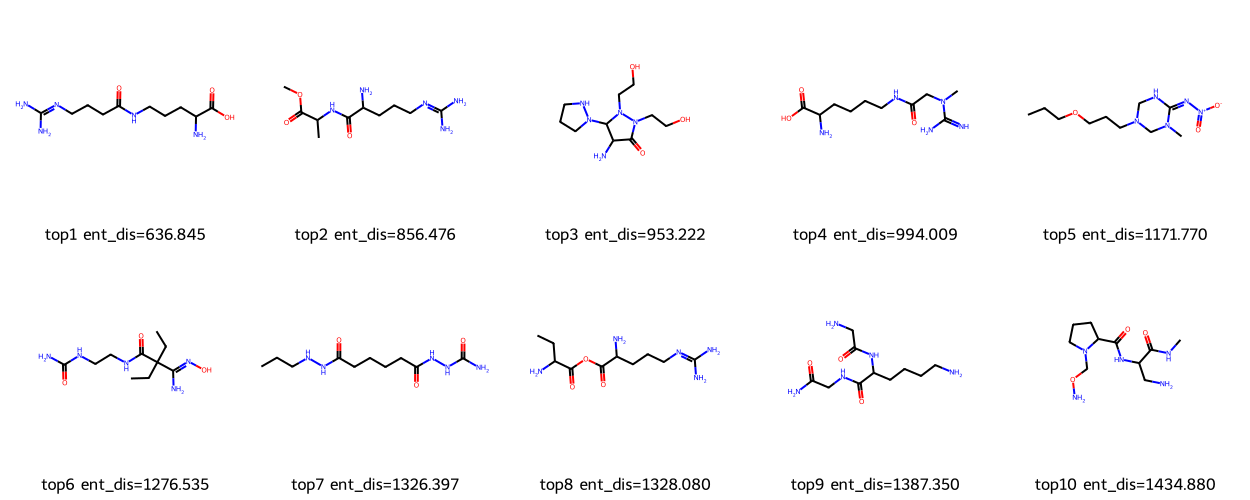

In [162]:
broad_elucidation('mxp4309', 'C10H21N5O3', r'O=C(NCCCC(O)=O)C(N)CCC/N=C(N)\N', 'Arg-GABA',
                  dist_fn=emd_dist_bin)

100%|██████████| 64/64 [00:02<00:00, 22.91it/s]


[Alanylhomoaruginine] Found target mol at 31/65, ent_dist=1572.842


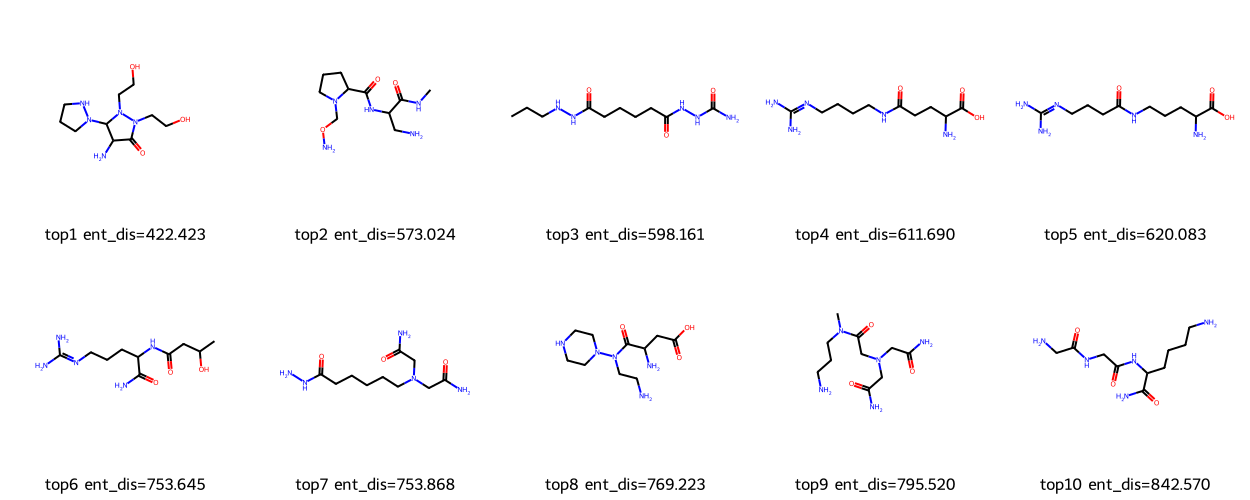

In [163]:
broad_elucidation('mxp4155', 'C10H21N5O3', r'C[C@@H](C(=O)N[C@@H](CCCCN=C(N)N)C(=O)O)N', 'Alanylhomoaruginine',
                  dist_fn=emd_dist_bin)

100%|██████████| 64/64 [00:02<00:00, 23.22it/s]


[2-(2-aminobutanamido)-5- [(diaminomethylidene)amino]pentanoic acid] Found target mol at 37/65, ent_dist=1750.101


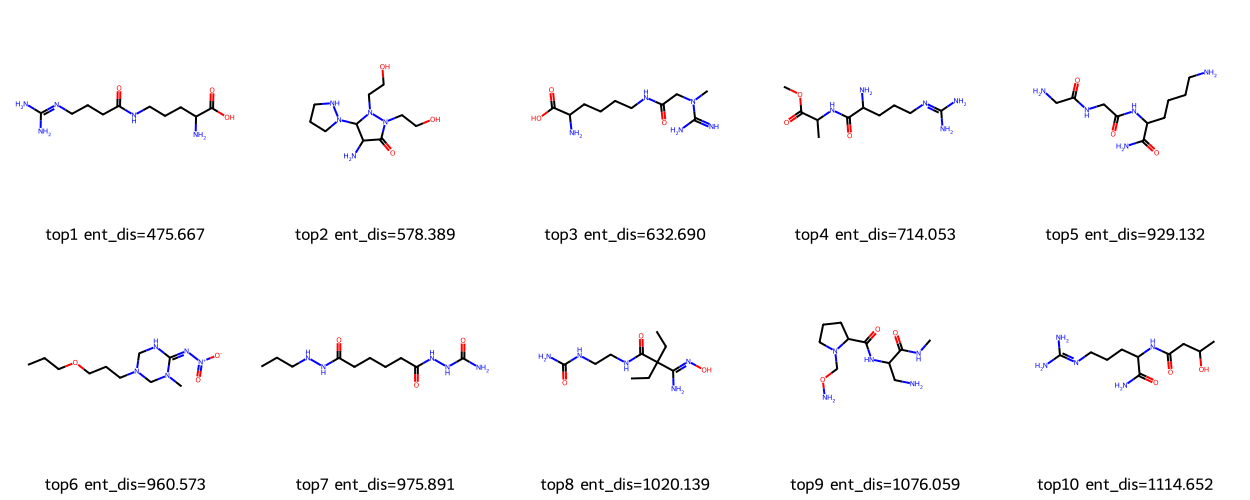

In [164]:
broad_elucidation('mxp4156', 'C10H21N5O3', r'N/C(N)=N\CCCC(C(O)=O)NC(C(N)CC)=O', '2-(2-aminobutanamido)-5- [(diaminomethylidene)amino]pentanoic acid',
                  dist_fn=emd_dist_bin)

100%|██████████| 64/64 [00:02<00:00, 23.17it/s]

[2-amino-5-{4 [(diaminomethylidene)amino]butanamido}pentanoic acid] Found target mol at 4/65, ent_dist=893.448


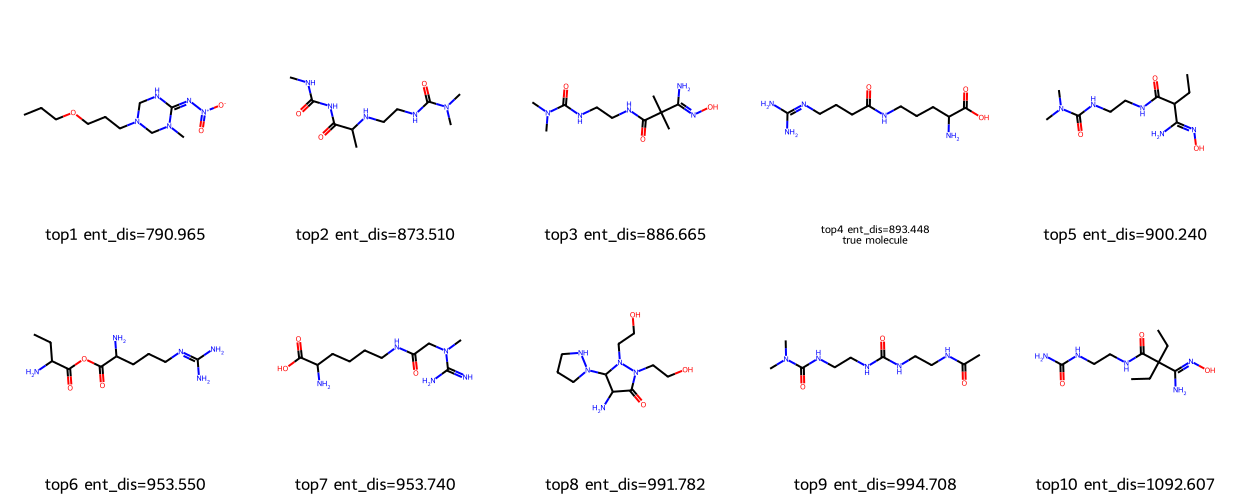

In [165]:
broad_elucidation('mxp4157', 'C10H21N5O3', r'O=C(O)C(N)CCCNC(CCC/N=C(N)\N)=O', '2-amino-5-{4 [(diaminomethylidene)amino]butanamido}pentanoic acid',
                    dist_fn=emd_dist_bin)

## OH-Tryptopha elucidation

In [ ]:
broad_elucidation('mxp4310', 'C11H12N2O3', 'C1=CC2=C(C(=C1)O)C(=CN2)CC(C(=O)O)N', '4-Hydroxy Tryptophan')

In [ ]:
broad_elucidation('mxp4310_all', 'C11H12N2O3', 'C1=CC2=C(C(=C1)O)C(=CN2)CC(C(=O)O)N', '4-Hydroxy Tryptophan (all peaks)')

In [ ]:
broad_elucidation('mxp0141', 'C11H12N2O3', 'C1=CC2=C(C=C1O)C(=CN2)C[C@@H](C(=O)O)N', '5-Hydroxy Tryptophan')

In [ ]:
broad_elucidation('mxp0141_all', 'C11H12N2O3', 'C1=CC2=C(C=C1O)C(=CN2)C[C@@H](C(=O)O)N', '5-Hydroxy Tryptophan (all peaks)')

In [ ]:
broad_elucidation('mxp4412', 'C11H12N2O3', 'C1=CC2=C(C(=C1)O)NC=C2CC(C(=O)O)N', '7-Hydroxy Tryptophan')

In [ ]:
broad_elucidation('mxp4412_all', 'C11H12N2O3', 'C1=CC2=C(C(=C1)O)NC=C2CC(C(=O)O)N', '7-Hydroxy Tryptophan (all peaks)')

In [ ]:
broad_elucidation('mxp4411', 'C11H12N2O3', 'C1=CC2=C(C=C1O)NC=C2C[C@@H](C(=O)O)N', '6-Hydroxy Tryptophan')

In [ ]:
broad_elucidation('mxp4411_all', 'C11H12N2O3', 'C1=CC2=C(C=C1O)NC=C2C[C@@H](C(=O)O)N', '6-Hydroxy Tryptophan (all peaks)')

In [ ]:
broad_elucidation('QI9873', 'C11H12N2O3', 'C1=CC2=C(C=C1)NC=C2C(O)[C@@H](C(=O)O)N')

# Tri peptite elucidation

In [ ]:
broad_elucidation('mxp4039', 'C17H32N4O4', r'CC(C)C[C@@H](C(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)N', 'Lys-Pro-Leu')

In [ ]:
broad_elucidation('mxp4040', 'C17H32N4O4', r'CC[C@H](C)[C@@H](C(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)N', 'Lys-Pro-Ile')

In [ ]:
broad_elucidation('mxp4041', 'C17H32N4O4', r'CC(C)C[C@@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCCN)C(=O)O)N', 'Leu-Pro-Lys')

In [ ]:
broad_elucidation('mxp4042', 'C17H32N4O4', r'CC[C@H](C)[C@@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCCN)C(=O)O)N', 'Ile-Pro-Lys')

## Food biomarkers

In [ ]:
broad_config = copy.deepcopy(config)
broad_config['nce'] = True # use nce for collision energy

# Get candidates
df = pd.read_csv('/home/roger/ms_collaborators/broad-Julian/24_0723_Compounds_to_generate_in_silico_MSMS.csv')

# fix formula mismatch
for idx, row in df.iterrows():
    df.at[idx, 'Chemical Formula'] = common.form_from_smi(row['SMILES'])

for formula in df['Chemical Formula'].unique():
    smiles = []
    for smi in df[df['Chemical Formula'] == formula]['SMILES']:
        smiles.append(common.rm_stereo(smi))

    # Run ICEBERG to predict spectra
    print(formula)
    result_path, pmz = iceberg_prediction(smiles, [10, 20, 30, 40, 50], **broad_config)
